# Analytics

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: YYYY/0X
##### Professor: Hilmer Neri

##### Members:

- Member x
- Member y

### LIBRARIES

In [416]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [417]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [418]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

In [419]:
repos = [
    '2021.1-Cartografia-social-api-comunidades',
    #'2021.1-Cartografia-social-api-gateway',
    #'2021.1-Cartografia-social-api-mapas',
    #'2021.1-Cartografia-social-api-midia',
    #'2021.1-Cartografia-social-api-users',
    #'2021.1-Cartografia-social-front'
]

language = [['2021.1-Cartografia-social-api-comunidades', 'ts']] 
            #['2021.1-Cartografia-social-api-gateway', 'ts'], 
            #['2021.1-Cartografia-social-api-mapas', 'ts'], 
            #['2021.1-Cartografia-social-api-midia', 'ts']] 
            #['2021.1-Cartografia-social-api-users', 'ts'], 
            #['2021.1-Cartografia-social-front', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

In [420]:
repos_language

{'2021.1-Cartografia-social-api-comunidades': 'ts'}

##### Path to the folder with all your jsons

In [421]:
jsons = glob('2021.1-Cartografia-social-api-comunidades/*.json') # add the path here

In [422]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [423]:
base_component_df = create_base_component_df(jsons)
#print(base_component_df)

In [424]:
base_component_df.head(50)

,metric,value,bestValue,filename,repository,version
54,duplicated_lines_density,0.0,True,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
55,functions,35,NaN,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
56,security_rating,1.0,True,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
57,files,30,NaN,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
58,complexity,35,NaN,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
59,ncloc,336,NaN,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
60,reliability_rating,1.0,True,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
61,comment_lines_density,0.0,False,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.1
9,duplicated_lines_density,0.0,True,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.2
10,functions,16,NaN,fga-eps-mds-2021_1-Cartografia-social-api-comu...,Cartografia-social-api-comunidades,v0.0.2


#### Create dataframe per file

In [425]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [426]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])

    df.to_csv('result2.csv')
    
    return df

In [427]:
file_component_df = create_file_df(jsons)


In [428]:
#print(file_component_df['version'])
file_component_df = file_component_df.sort_values(by='version')
#print(file_component_df)

In [429]:
#file_component_df.head(100)
file_component_df.repository.unique()

array(['Cartografia-social-api-comunidades'], dtype=object)

#### Create dataframe per repository

In [430]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['2021.1-Cartografia-social-api-comunidades'])

In [431]:
api_comunidades_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-comunidades']
...
#api_gateway_df = file_component_df[file_component_df['repository'] == '2021.1-Cartografia-social-api-gateway']
#api_mapas_df = file_component_df[file_component_df['repository'] == '2021.1-Cartografia-social-api-mapas']
#api_midia_df = file_component_df[file_component_df['repository'] == '2021.1-Cartografia-social-api-midia']
#api_users_df = file_component_df[file_component_df['repository'] == '2021.1-Cartografia-social-api-users']
#front_df = file_component_df[file_component_df['repository'] == '2021.1-Cartografia-social-api-front']

print(api_comunidades_df)

                                                  path functions complexity  \
58                                test/app.e2e-spec.ts         3          3   
78     src/questionario/dto/update-questionario.dto.ts         0          0   
77   src/questionario/entities/survey_response.sche...         0          0   
76       src/questionario/dto/sendSurveyAsnwers.dto.ts         0          0   
75            src/questionario/questionario.service.ts         3          3   
74      test/questionario/questionario.service.spec.ts         8          8   
73    src/questionario/entities/questionario.schema.ts         0          0   
72             src/questionario/questionario.module.ts         0          0   
71         src/questionario/questionario.controller.ts         3          3   
69                                         src/main.ts         2          2   
70   test/questionario/questionario.controller.spec.ts         5          5   
67                         src/config/configuration.

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [432]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [433]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [434]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [435]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [436]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [437]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [438]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [439]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list
                              })
        
    return metrics_df

In [440]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df
    
repository_dataframes.keys()

dict_keys(['2021.1-Cartografia-social-api-comunidades'])

In [441]:
api_comunidades_metrics = create_metrics_df(api_comunidades_df)
...
#api_gateway_metrics = create_metrics_df(api_gateway_df)
#api_mapas_metrics = create_metrics_df(api_mapas_df)
#api_midia_metrics = create_metrics_df(api_midia_df)
#api_users_metrics = create_metrics_df(api_users_df)
#front_metrics = create_metrics_df(front_df)

In [442]:
all_metrics = pd.concat([api_comunidades_metrics, api_gateway_metrics, api_mapas_metrics, api_midia_metrics, api_users_metrics, front_metrics], ignore_index=True)

### Data visualization

- You must do this for each of your repositories

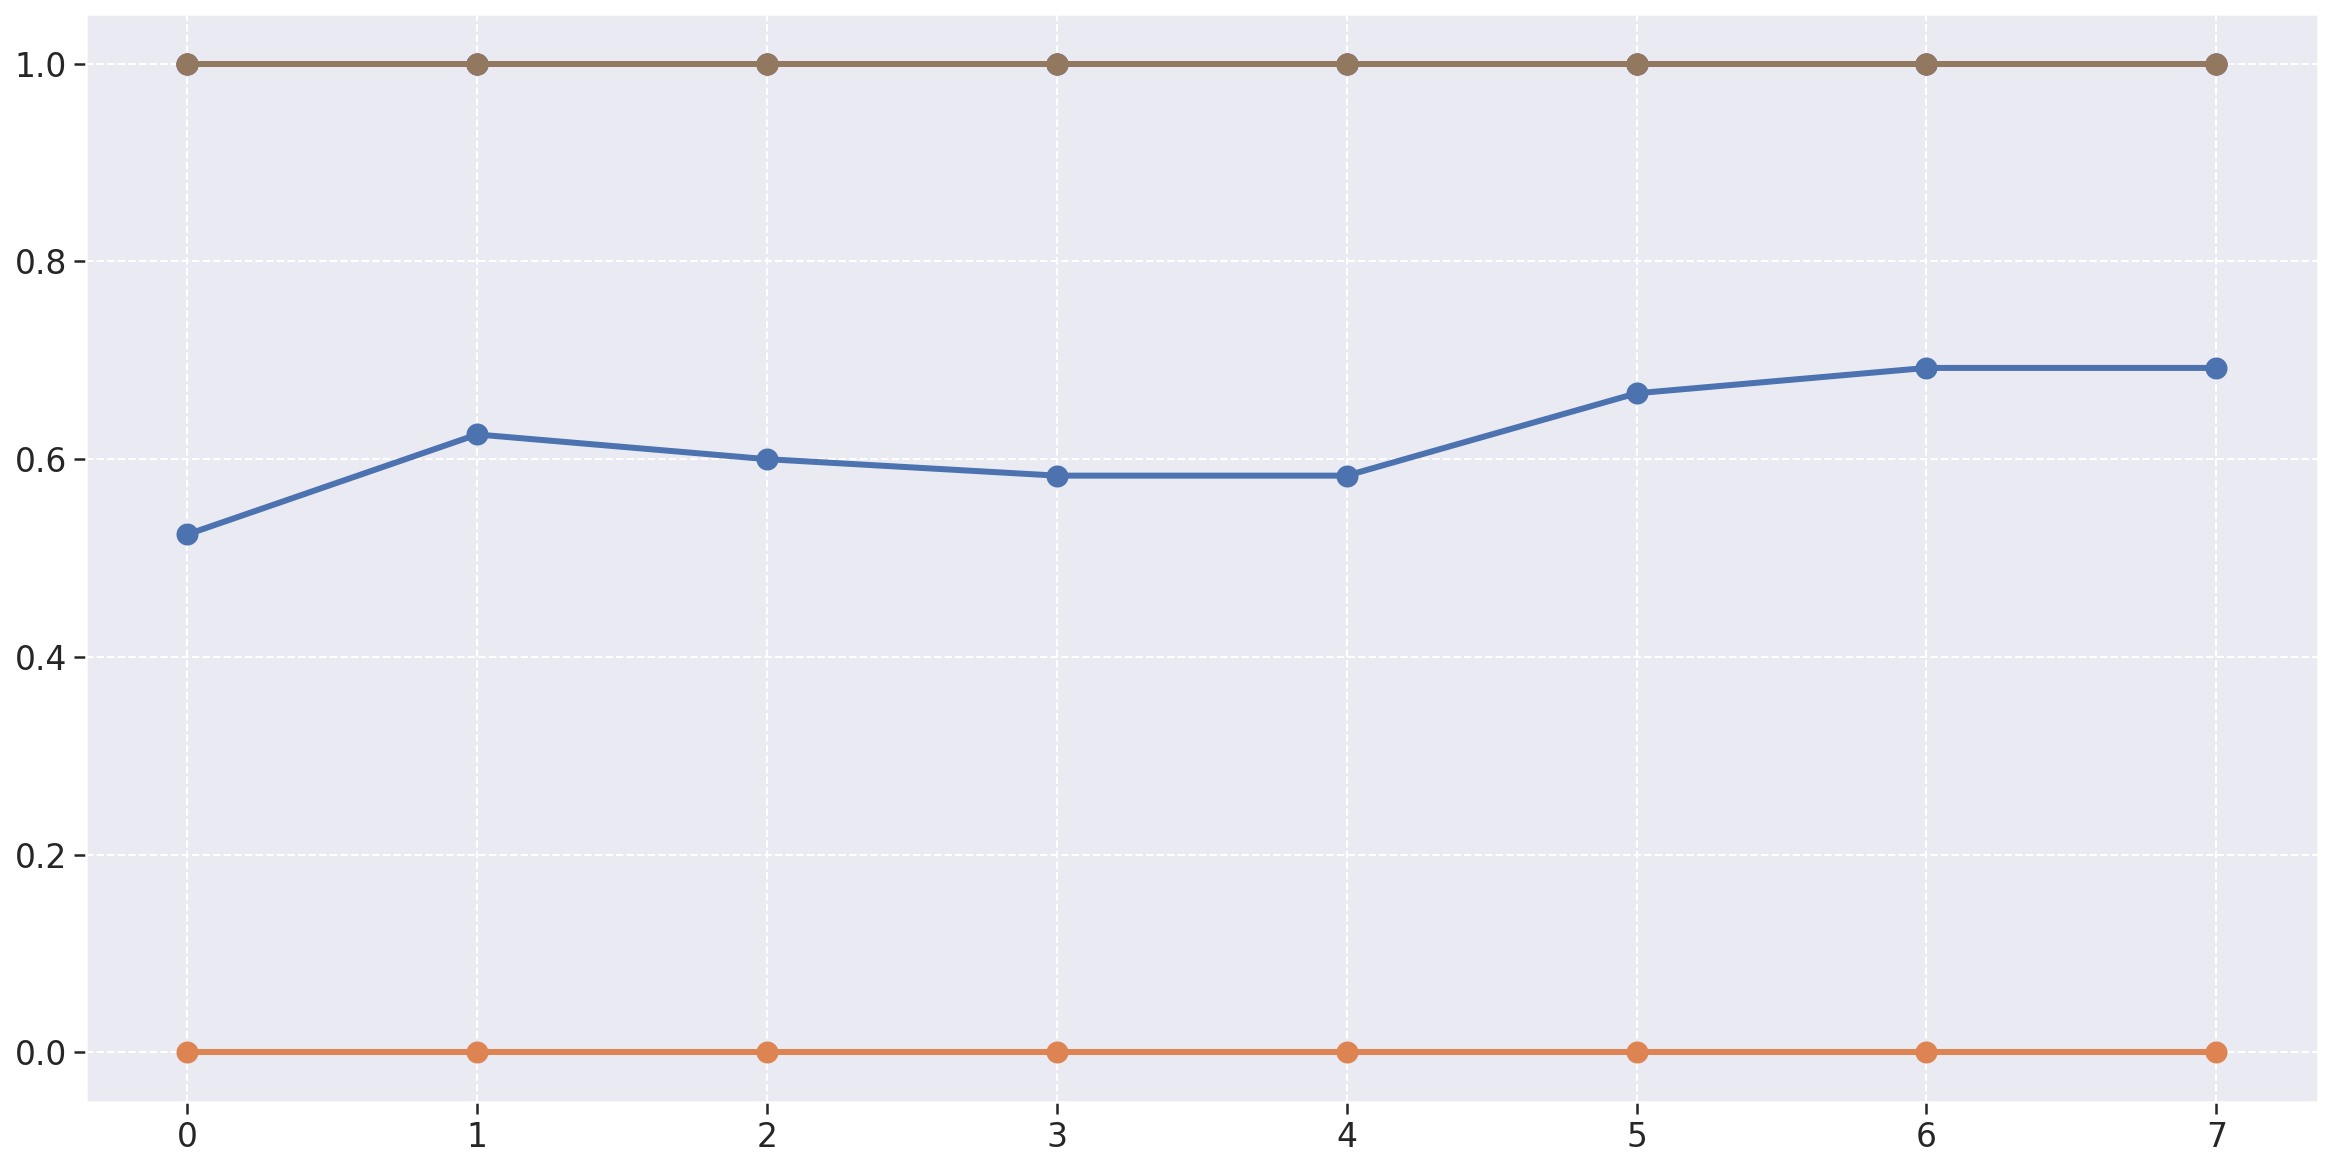

In [443]:
fig = plt.figure(figsize=(20, 10))

plt.plot(api_comunidades_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(api_comunidades_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(api_comunidades_metrics['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(api_comunidades_metrics['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(api_comunidades_metrics['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(api_comunidades_metrics['m6'], linewidth=3, marker='o', markersize=10)

In [444]:
generic_df = api_comunidades_metrics.copy()
repository = "API-COMUNIDADES"

In [445]:
plot_history(generic_df, repository)

NameError: name 'plot_history' is not defined

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo2['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m6'], linewidth=3, marker='o', markersize=10)

...

### Sub characteristic aggregation

- You must do this for each of your repositories

In [ ]:
psc1, psc2 = 1
pc1, pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

repo1['code_quality'] = ((repo1['m1']*pm1) + (repo1['m2']*pm2) + (repo1['m3']*pm3)) * psc1
repo2['code_quality'] = ((repo2['m1']*pm1) + (repo2['m2']*pm2) + (repo2['m3']*pm3)) * psc1
...

repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2
repo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2
...

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(repo1['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['code_quality'], linewidth=3, marker='o', markersize=5)
...

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(repo1['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['testing_status'], linewidth=3, marker='o', markersize=5)
...


In [ ]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, ...], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [ ]:
metrics_df

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5)


plt.ylim(.45,.7)

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


plt.ylim(.45,.7)


In [ ]:
# ANALYSIS_DATE FORMAT: MM-DD-YYYY

metrics_df.to_excel('data/ga-eps-mds-2021_1-NOME_PROJETO-DATASET-ANALYSIS_DATE.xlsx', index = False)
metrics_df.to_csv('data/ga-eps-mds-2021_1-NOME_PROJETO-DATASET-ANALYSIS_DATE.csv', index = False)